# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

## Background
Photonic crystals (PhC) are micro/nano artificial atoms composed of periodically perturbed refractive indices dielectric material, which can manipulate the propagation of electromagnetic (EM) waves in a similar manner to how actual crystals manipulate electron waves. The periodic symmetry and Maxwell equations guarantee that the eigenmodes of EM waves can be held in PhC are represented by photonic band structures. One popular method to analyze the band structures of photonic crystals is to apply the Hamiltonian formalism, however, the method to select Hamiltonian basis has been left unrevealed in the majority of related papers. This will be the main purpose of our project.

## Generative Model: The Hamiltonian Matrix
The Hamiltonian matrix consists of coupling parameters that describe the interaction between different Bloch waves in the basis. At each value of $(k_x,k_y)$, the energy levels can be obtained by diagonalizing the Hamiltonian matrix and finding its eigenvalues. Due to the C4 symmetry of our square lattice, the allowed basis sizes are 5, 9, 13,...

Right now, this package allows you to infer the coupling parameters in a 5 basis model: 5 Bloch waves at $\Gamma$ point and its four surrounding symmetric points in $k-$space, whoses interaction can be described by 6 coupling parameters.

![title](reference_img/5-basis-doodle.png)

$U_{10},U_{11}$ and $U_{20}$ represent couplings between Bloch waves at different $k$ points, $\epsilon_0$ being the energy of the Bloch wave at the $\Gamma$ point, $\epsilon_x$ being the energy of other Bloch waves along $k_x$, $\epsilon_y$ being the energy of other Bloch waves along $k_y$. Let $P_1$ be the $\Gamma$ point, $P_2,P_3,P_4,P_5$ be the 4 points surrounding it by a clock-wise order starting at the point below the $\Gamma$ point. If we describe the model in the basis of $\{ P_1,P_2,P_3,P_4,P_5\}$, then the corresponding Hamiltonian matrix is:
$$ H =  \begin{pmatrix} \epsilon_0 & U_{10}& U_{10}& U_{10}& U_{10} \\ U_{10}& \epsilon_y & U_{11}& U_{20}& U_{11} \\ U_{10}& U_{11}& \epsilon_x & U_{11}& U_{20} \\ U_{10}& U_{20}&U_{11}& \epsilon_y & U_{11}\\ U_{10}& U_{11}&U_{20}& U_{11}  & \epsilon_x  \end{pmatrix}$$

The matrix is inherently diagonalizable and has the eigenvalues $\{ e_0,e_1,e_2,e_3,e_4\}$. 

From the measurement data, the energy mode at $\Gamma$ point is always too weak to detect. Therefore, one can simplify the model further to include basis of 4 k-vectors $\{P_2,P_3,P_4,P_5\}$ only. Our reduced Hamiltonian matrix becomes 
$$ H_{reduced} =  \begin{pmatrix} \epsilon_y & U_{11}& U_{20}& U_{11} \\ U_{11}& \epsilon_x & U_{11}& U_{20} \\ U_{20}&U_{11}& \epsilon_y & U_{11}\\ U_{11}&U_{20}& U_{11}  & \epsilon_x  \end{pmatrix}$$

And the eigenvalues $\{e_1,e_2,e_3,e_4\}$ represent 4 energy bands of the photonic crystal.

### Multiple Lorentzian Peak Model of the energy spectrum

In real measurement, 4 energy bands of the photonic crystals appear as four peaks in the frequency-intensity line plot. Therefore, our model for the energy spectrum is a multiple Lorentzian peak model where the peak positions are $\{e_1,e_2,e_3,e_4\}$.  The background $A_0$, amplitudes of four peaks $A_1, A_2, A_3, A_4$ and the peak width $W_1, W_2, W_3, W_4$ are the nuisance parameters that we will marginalize over.

$$ y_{predicted} = A_0 + \sum_1^4 A_i \text{Lorentzian}(e_i, W_i)$$

Firstly, we need to choose the priors for the parameters. For the coupling parameters $U_{11}$ and $U_{20}$, we know their lower and upper bounds from previous experiments (Reference ?). For the peak background and amplitudes, they are bounded by zero and the saturated intensity of the CCD detector. For the peak width, it is also bounded by the resolution in frequency of the laser and (?)  Since other these bounds we don't have any other information about the distributions of these parameters, in this package, we used uniform priors for all parameters.

$$\theta_n \sim \text{Uniform} (\theta_{n,min},\theta_{n,max})$$

for $\theta_n$ in $\{U_{11}, U_{20}, A_0, A_1, A_2, A_3, A_4, \sigma_L \}$. Note that for the uncoupling energies $\epsilon_x$ and $\epsilon_y$, we can extract their exact values from the (reference?) and use them as prior information.

Secondly, we consider all the uncertainty sources in measuring the light intensity such as beam profile, CCD sensitivity,...(?) These uncertainties are all Gaussian-like, thus, our likelihood is also well-described by Gaussian distribution:

$$y \sim \text{Gaussian} (y_{predicted}, \sigma_y)$$

## Using the photonic-hamiltonian package

### Load the data file

Before using the package, please make sure that the data is converted into .nc format

Our io_data.py script provides the $\textbf{load_data(filename)}$ function which exports the data in .nc format into an xarray with data labels 'normf', 'y1', 'y2', 'y3', 'y4', which indicates four repeating measurement results

In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
import seaborn as sns

from photonic_hamiltonian.inference import io_data
#load an example data file, data courtersy: Fan Du
real_data = io_data.load_data('photonic_hamiltonian\data\expdata_singleKspectrum_060.nc')

We can plot this data to visualize how the four peaks look like in a real measurement

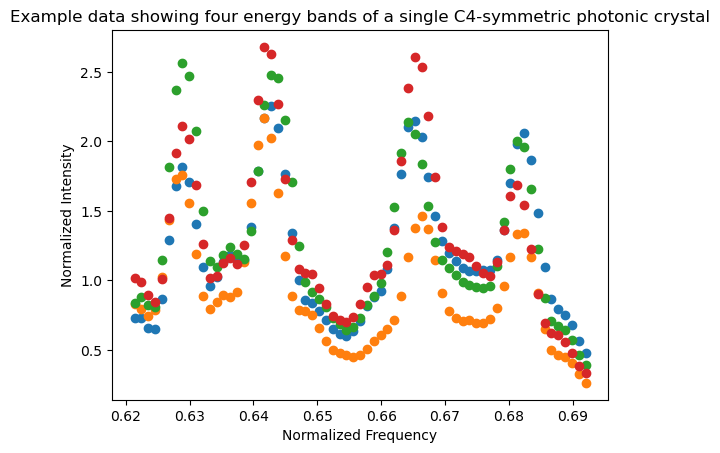

In [7]:
freq = real_data['normf'].to_numpy()
intensity = np.zeros((4,len(freq)))
intensity[:] = [real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']]
plt.plot(freq, intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')
plt.show()

### Inference fit using pymc

In the package, the Model.py script has two functions: Hamiltonian_model and prediction_model

$\textbf{Hamiltonian_model(data, prior_bounds)}$ function:
* It is used to define, diagonalize the Hamiltonian matrix, and build a multi Lorentzian peak model from the matrix's eigenvalues. You can use this pymc model for sampling, plotting the posterior, or finding the maximum a posteriori (MAP) point to extract fit parameters.
* Its input parameters are data extracted and formatted by io.py, and a dictionary which maps parameters' names ('u11', 'u20', 'e0', 'de', 'A0', 'A1', 'A2', 'A3' , 'A4', 'W1', 'W2', 'W3', 'W4', 'sigma_y') to their corresponding prior types and coefficients.

$\textbf{prediction_model(theta, freq)}$ function:
 * It calculates the fitted intensity for a given set of fitting parameters
 * Its input parameters are the normalized frequency and a list of fitting parameters in the order [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]

In [9]:
from photonic_hamiltonian.inference import Model

#### Inference on simulated data

To test if running our model gives a reasonable result for parameter estimation, we first generate a simulated data with given values for all the parameters

Text(0.5, 1.0, 'Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

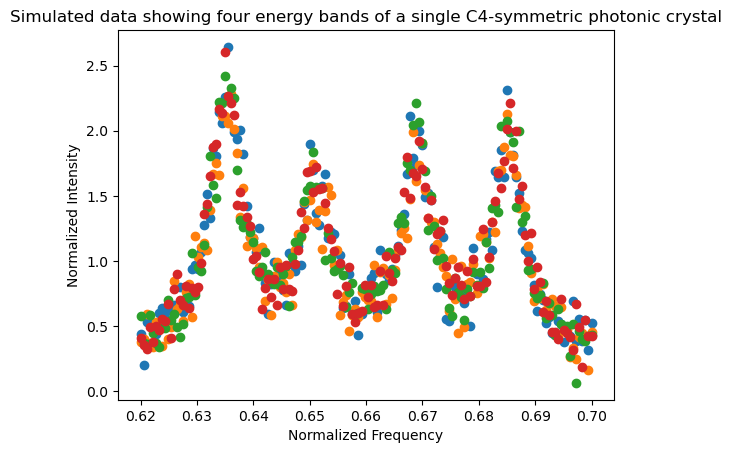

In [10]:
# Create simulated data
N = 150
simu_normf = np.linspace(0.62,0.70,N)    # create normalized frequency, "x" variable 

#set all hamiltonian parameters as some constants
u11 = 0.008
u20 = 5e-5
e0 = 0.66
de = 0.015
A0 = 0.3
[A1,A2,A3,A4] = [1.9,1.2,1.5,1.6]
[Q1,Q2,Q3,Q4] = [180,200,210,220]
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1,Q2,Q3,Q4]
#create normalized intensity
line = Model.prediction_model(theta, simu_normf)

#create noise
sigma_noise = 0.15

#create data array
simu_data = xr.Dataset(data_vars = {'y1': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N) ),
                                    'y2': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N)  ),
                                    'y3': ('normf', line + np.sqrt(line)*np.random.normal(0, sigma_noise, N) ),
                                    'y4': ('normf', line +np.sqrt(line)*np.random.normal(0, sigma_noise, N)  )},
                     coords = { 'normf': simu_normf})

#plot the simulated data to visualize the four peaks
simu_intensity = np.zeros((4,len(simu_normf)))
simu_intensity[:] = [simu_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']]
plt.plot(simu_normf, simu_intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

From the raw data, we can guess some reasonable bounds for our priors.

In [13]:
#guess the prior bounds
prior_A = [0.5, 2.5]
prior_W = [0.001, 0.03]
Q = [1/200]
simu_priors = {'u11':('Normal', [0.008, 0.0002]),
               'u20':('Normal', [0.001, 0.0001]),
               'e0':('Uniform', [0.65, 0.67]),
               'de':('Uniform', [0.01, 0.02]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', [1/1.6]),
               'A2':('Exponential', [1/1.6]),
               'A3':('Exponential', [1/1.6]),
               'A4':('Exponential', [1/1.6]),
               'Q1':('Exponential', Q ), 
               'Q2':('Exponential', Q ),
               'Q3':('Exponential', Q ),
               'Q4':('Exponential', Q ),
               'sigma_y':('Exponential', [1/0.15])}

#create the model 
simu_ham_model = Model.Hamiltonian_model(simu_data, simu_priors)

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 103 seconds.


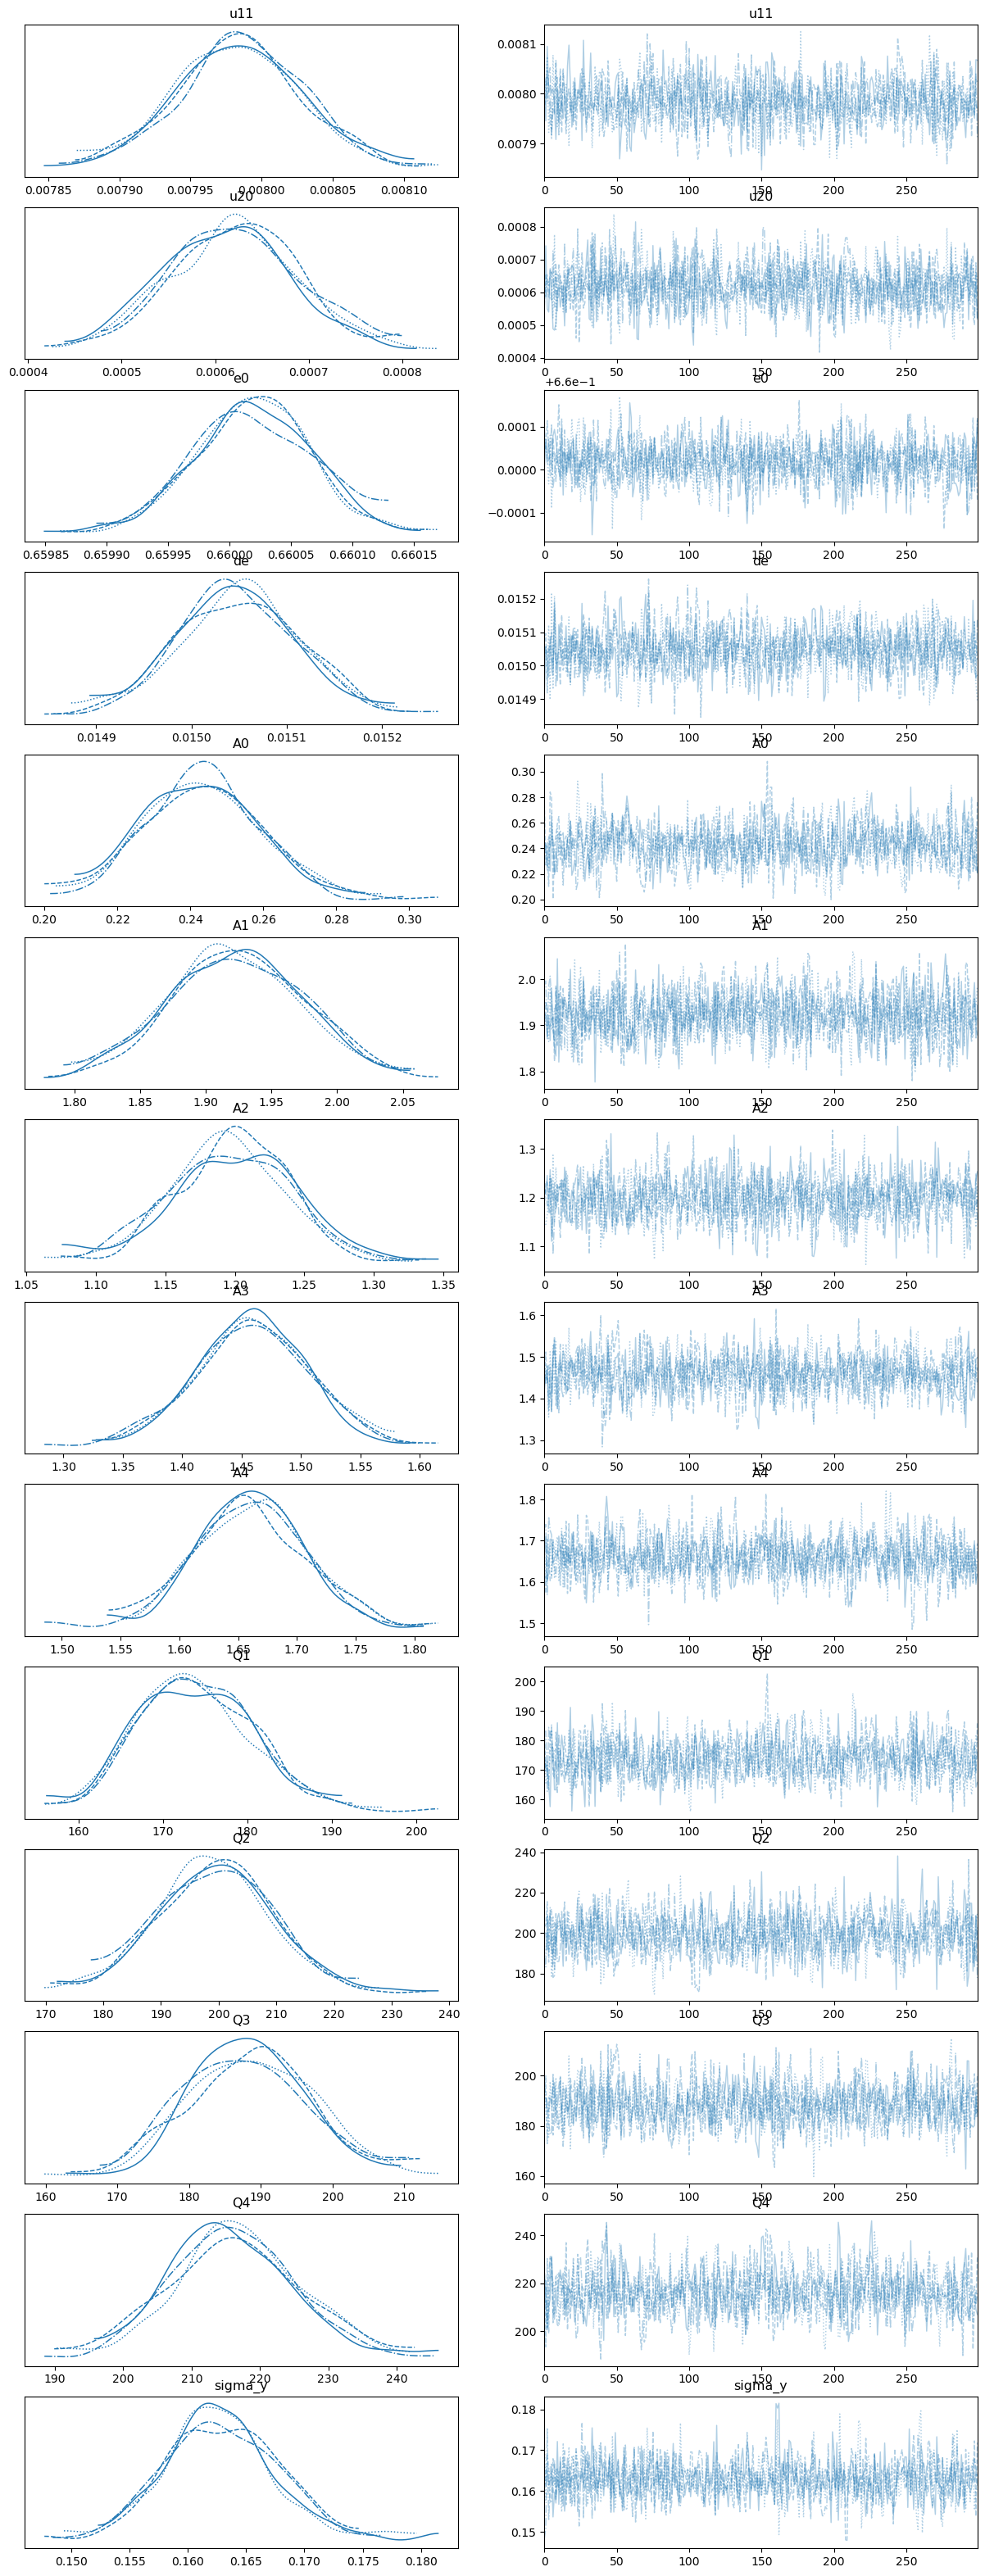

In [14]:
with simu_ham_model:
    simu_idata = pm.sample(300)

az.plot_trace(simu_idata, figsize=(15,40));

In [15]:
#summary the fitting results
simu_summary = az.summary(simu_idata,round_to=8)
display(simu_summary)

mean         sd      hdi_3%     hdi_97%  mcse_mean  \
u11        0.007984   0.000044    0.007905    0.008075   0.000001   
u20        0.000619   0.000069    0.000489    0.000746   0.000002   
e0         0.660019   0.000048    0.659924    0.660107   0.000001   
de         0.015049   0.000064    0.014929    0.015174   0.000002   
A0         0.243130   0.015905    0.216846    0.275963   0.000469   
A1         1.923071   0.051594    1.813817    2.007970   0.001149   
A2         1.197979   0.044419    1.116659    1.284350   0.001117   
A3         1.459474   0.046981    1.367689    1.547009   0.001265   
A4         1.660791   0.047494    1.581595    1.756235   0.001306   
Q1       173.791394   6.694399  162.180123  186.491304   0.189833   
Q2       199.306762  10.125102  180.127691  218.363765   0.272152   
Q3       188.440565   8.410535  173.339242  204.022454   0.231061   
Q4       216.223253   9.261968  198.956348  233.231271   0.276998   
sigma_y    0.162868   0.004846    0.153658    0.171467   0.000117   

              mcse_sd     ess_bulk     ess_tail     r_hat  
u11      8.100000e-07  1487.598595   907.648230  1.000990  
u20      1.170000e-06  1735.502324   994.302172  1.002354  
e0       8.200000e-07  1717.876987  1039.930814  0.999616  
de       1.120000e-06  1652.366603   775.462521  1.000365  
A0       3.319600e-04  1148.073996   788.455068  1.001763  
A1       8.139300e-04  2039.412757  1000.892096  1.001063  
A2       7.898100e-04  1565.453987  1022.025573  1.003355  
A3       8.948800e-04  1378.532710   908.391669  1.000677  
A4       9.249500e-04  1351.055470   869.663006  0.999792  
Q1       1.345929e-01  1258.542472   985.229724  0.999855  
Q2       1.924808e-01  1371.412984   828.731378  0.999507  
Q3       1.638001e-01  1317.240720   888.778396  1.002416  
Q4       1.967051e-01  1123.964853   795.503637  0.999199  
sigma_y  8.314000e-05  1756.405608   958.495745  1.004313

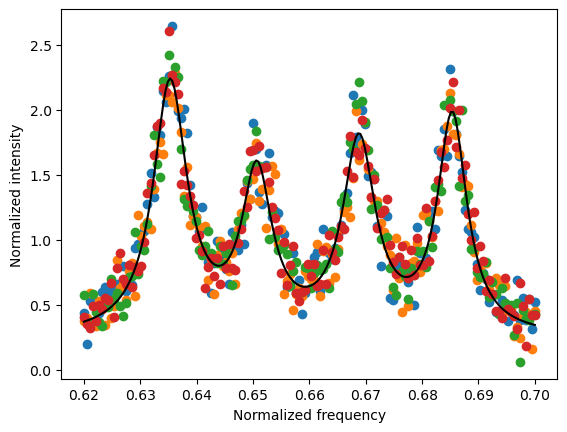

In [16]:
#plot data with the fitting curve
import pytensor.tensor as pt
u11, u20, e0, de, A0, A1, A2, A3, A4, Q1,Q2,Q3,Q4,sigma_y = simu_summary['mean'].values
simu_theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1,Q2,Q3,Q4]
model_predictions = Model.prediction_model(simu_theta, np.linspace(0.62,0.70,200))
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(simu_normf, simu_intensity.T, 'o')
plt.plot(np.linspace(0.62,0.70,200), model_predictions, 'k');

We can see that all these marginalized posteriors are peaked at the correct values of parameters that we used to generate the simulated data. Thus, our package works reasonably well with the simulated data.

#### Inference on real data

Similar to what we did with the simulated data, we need to look at the raw data, guess the bounds for peak parameters and then sample with generative model.

In [26]:
#guess the prior bounds
prior_A = [0.8, 2.5]
prior_Q = [100,300]
priors = simu_priors = {'u11':('Uniform', [0.005, 0.01]),
               'u20':('Uniform', [0, 0.003]),
               'e0':('Uniform', [0.64, 0.67]),
               'de':('Uniform', [0.005, 0.025]),
               'A0':('Uniform', [0, 0.5]),
               'A1':('Uniform', prior_A),
               'A2':('Uniform', prior_A),
               'A3':('Uniform', prior_A),
               'A4':('Uniform', prior_A),
               'Q1':('Uniform', prior_Q), 
               'Q2':('Uniform', prior_Q),
               'Q3':('Uniform', prior_Q),
               'Q4':('Uniform', prior_Q),
               'sigma_y':('Uniform', [0.1,0.5])}

#create the model 
ham_model = Model.Hamiltonian_model(real_data, priors)

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 103 seconds.


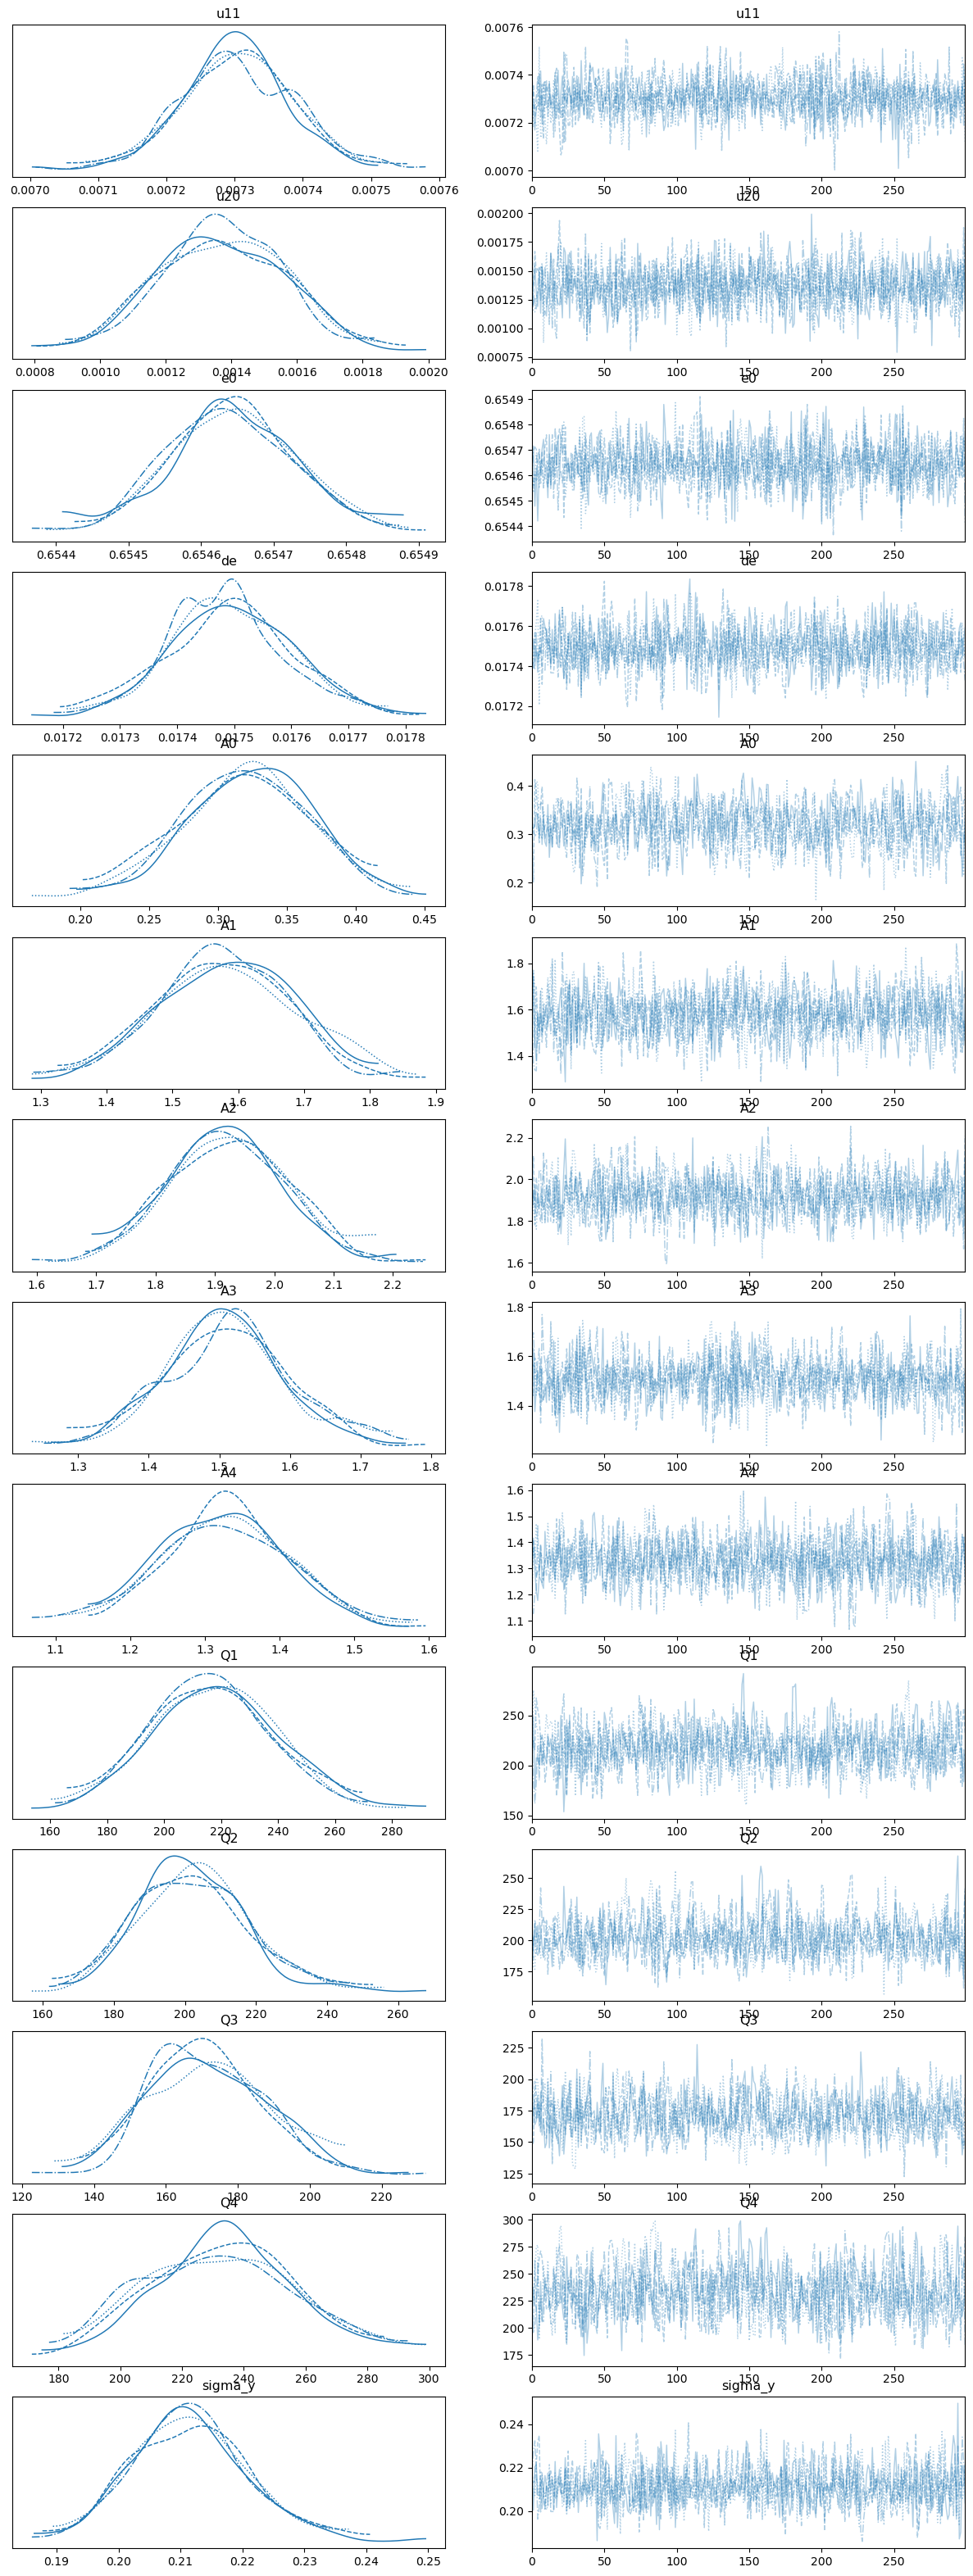

In [27]:
with ham_model:
    idata = pm.sample(300)

az.plot_trace(idata, figsize=(15,40));

In [28]:
#summary the fitting results
summary = az.summary(idata, round_to=8)
display(summary)

mean         sd      hdi_3%     hdi_97%  mcse_mean   mcse_sd  \
u11        0.007304   0.000081    0.007161    0.007464   0.000002  0.000001   
u20        0.001370   0.000192    0.001014    0.001712   0.000004  0.000003   
e0         0.654643   0.000088    0.654482    0.654812   0.000002  0.000001   
de         0.017492   0.000107    0.017279    0.017692   0.000003  0.000002   
A0         0.320476   0.046017    0.229955    0.403412   0.001632  0.001164   
A1         1.579186   0.102104    1.390662    1.769051   0.002645  0.001871   
A2         1.921736   0.099899    1.711818    2.087293   0.002726  0.001933   
A3         1.509300   0.087137    1.345346    1.675878   0.002291  0.001645   
A4         1.326838   0.086517    1.164166    1.489778   0.002322  0.001643   
Q1       217.134678  21.697627  175.570327  256.756746   0.710853  0.505950   
Q2       202.447327  16.249039  174.155118  235.013761   0.508031  0.366142   
Q3       171.458656  16.309241  143.217379  202.332478   0.520033  0.367828   
Q4       233.430864  23.992248  191.113597  279.546495   0.838217  0.602763   
sigma_y    0.211450   0.009169    0.192906    0.227738   0.000198  0.000142   

            ess_bulk     ess_tail     r_hat  
u11      1792.140936   865.158860  1.002801  
u20      1818.877439  1076.431188  1.008380  
e0       2021.016466   996.474289  0.999760  
de       1711.605558   993.409994  1.001013  
A0        792.199955   843.640257  1.003112  
A1       1477.640531   803.638694  1.001077  
A2       1345.313186  1106.537375  1.000377  
A3       1429.107979   764.414019  1.002692  
A4       1384.055450   895.011895  1.007467  
Q1        932.034174   769.236851  1.001007  
Q2       1083.397337   691.796614  1.001640  
Q3        972.518401   841.688515  1.001812  
Q4        822.406508   608.601086  1.002580  
sigma_y  1952.287712   886.711130  1.001834

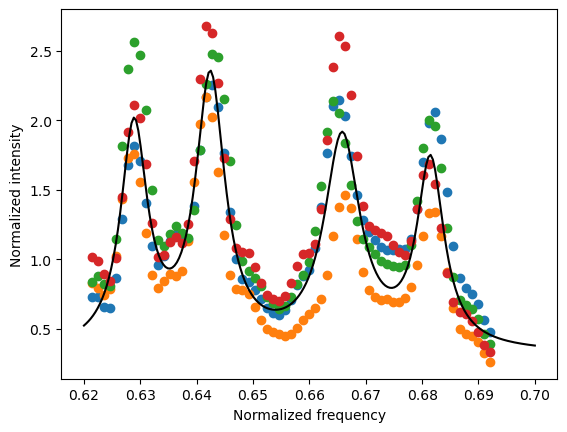

In [29]:
#plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4,  Q1,Q2,Q3,Q4, sigma_y = summary['mean'].values
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4,  Q1,Q2,Q3,Q4]
model_predictions = Model.prediction_model(theta, np.linspace(0.62,0.70,200))
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(freq, intensity.T, 'o')
plt.plot(np.linspace(0.62,0.70,200), model_predictions,'k')

## Use proper priors 

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 103 seconds.


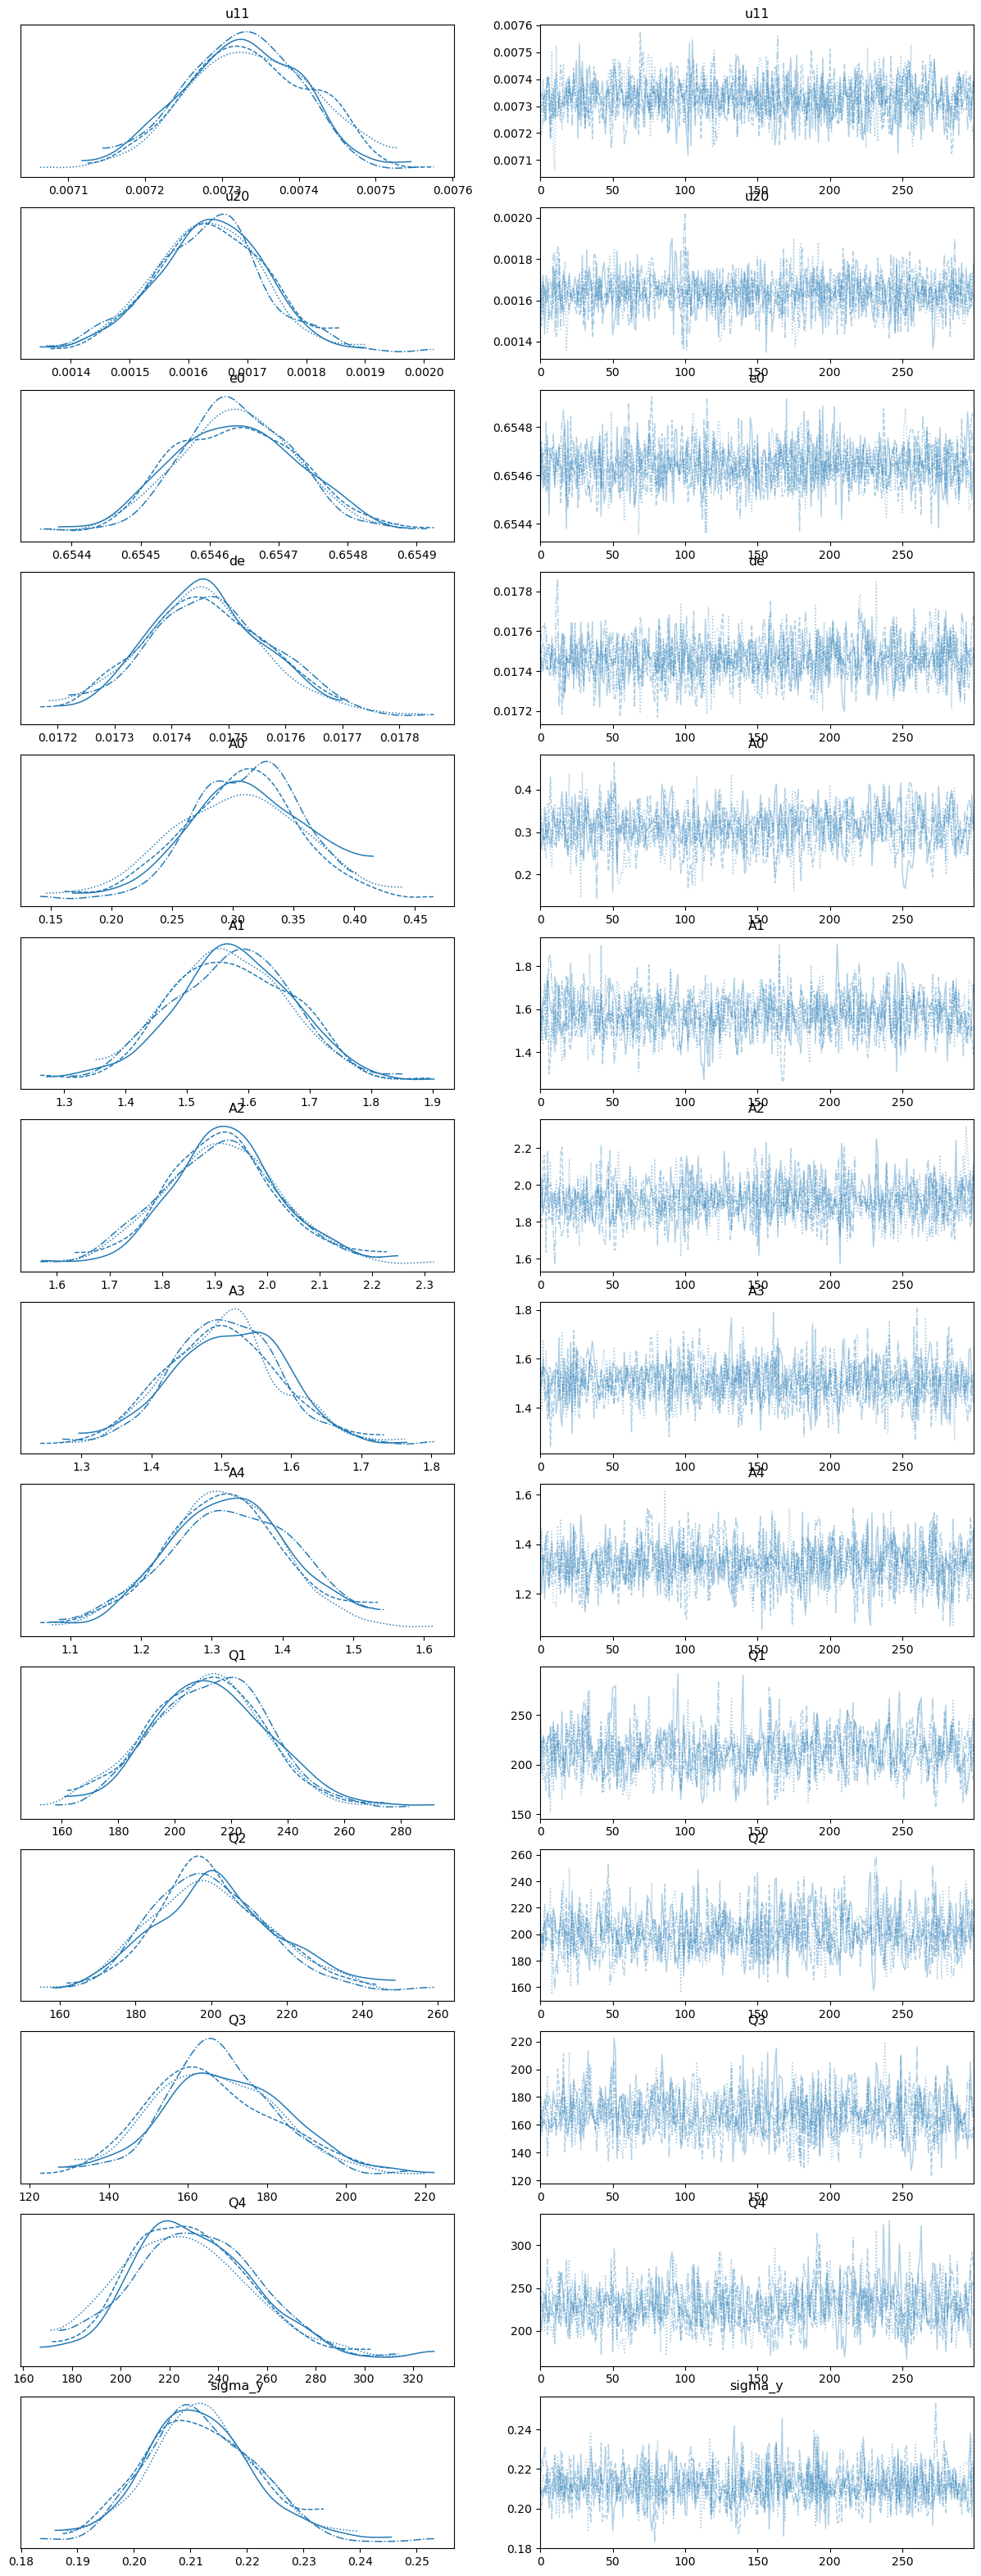

In [8]:
## attempt with more physical priors
#guess the prior bounds
prior_A = [0.5, 2.5]
prior_W = [0.001, 0.03]
Q = [1/200]
priors_2 = {'u11':('Normal', [0.0074, 0.0002]),
               'u20':('Normal', [0.0017, 0.0001]),
               'e0':('Uniform', [0.64, 0.67]),
               'de':('Uniform', [0.005, 0.025]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', [1/1.6]),
               'A2':('Exponential', [1/1.6]),
               'A3':('Exponential', [1/1.6]),
               'A4':('Exponential', [1/1.6]),
               'Q1':('Exponential', Q ), 
               'Q2':('Exponential', Q ),
               'Q3':('Exponential', Q ),
               'Q4':('Exponential', Q ),
               'sigma_y':('Exponential', [1/0.2])}

#create the model 
ham_model = Model.Hamiltonian_model(real_data, priors_2)
with ham_model:
    idata = pm.sample(300)

az.plot_trace(idata, figsize=(15,40));

mean         sd      hdi_3%     hdi_97%  mcse_mean   mcse_sd  \
u11        0.007331   0.000078    0.007186    0.007474   0.000002  0.000002   
u20        0.001635   0.000093    0.001442    0.001803   0.000002  0.000002   
e0         0.654640   0.000090    0.654468    0.654801   0.000002  0.000002   
de         0.017460   0.000108    0.017274    0.017675   0.000003  0.000002   
A0         0.308791   0.048894    0.222447    0.403137   0.001793  0.001268   
A1         1.573238   0.097167    1.392944    1.748086   0.002894  0.002047   
A2         1.916266   0.108297    1.710771    2.121708   0.002902  0.002062   
A3         1.506255   0.082866    1.347346    1.654673   0.002330  0.001648   
A4         1.322562   0.087217    1.160824    1.486396   0.002364  0.001675   
Q1       212.555415  21.497733  170.804233  251.060660   0.699983  0.496699   
Q2       200.782414  16.554012  171.442734  234.269843   0.478628  0.340364   
Q3       168.006974  15.686848  139.870040  199.108307   0.542084  0.383445   
Q4       229.064806  25.463718  182.951774  277.633397   0.957594  0.682031   
sigma_y    0.211888   0.009491    0.194612    0.229741   0.000251  0.000178   

            ess_bulk     ess_tail     r_hat  
u11      1265.533479   804.969720  1.004269  
u20      1689.631442   574.936290  1.000515  
e0       1600.675013   898.059022  1.000710  
de       1531.918315  1029.666008  1.002449  
A0        768.346187   512.110025  1.008763  
A1       1122.252527   910.988931  1.001633  
A2       1394.966617   950.871622  1.002095  
A3       1254.263852  1021.784690  1.000371  
A4       1362.080434   818.907716  1.004832  
Q1        942.913632   829.980082  1.005091  
Q2       1206.278934   909.697824  1.005081  
Q3        819.482775   745.958889  1.005738  
Q4        722.304936   595.322817  1.008545  
sigma_y  1453.585351   978.076193  0.999060

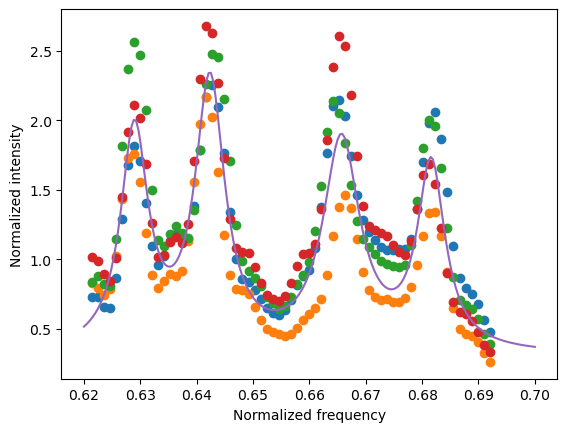

In [9]:
#summary the fitting results
summary = az.summary(idata, round_to=8)
display(summary)
#plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y = summary['mean'].values
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]
model_predictions = Model.prediction_model(theta, np.linspace(0.62,0.70,200))
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(freq, intensity.T, 'o')
plt.plot(np.linspace(0.62,0.70,200), model_predictions)

array([[<AxesSubplot: ylabel='u20'>, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='e0'>, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: xlabel='u11', ylabel='de'>,
        <AxesSubplot: xlabel='u20'>, <AxesSubplot: xlabel='e0'>]],
      dtype=object)

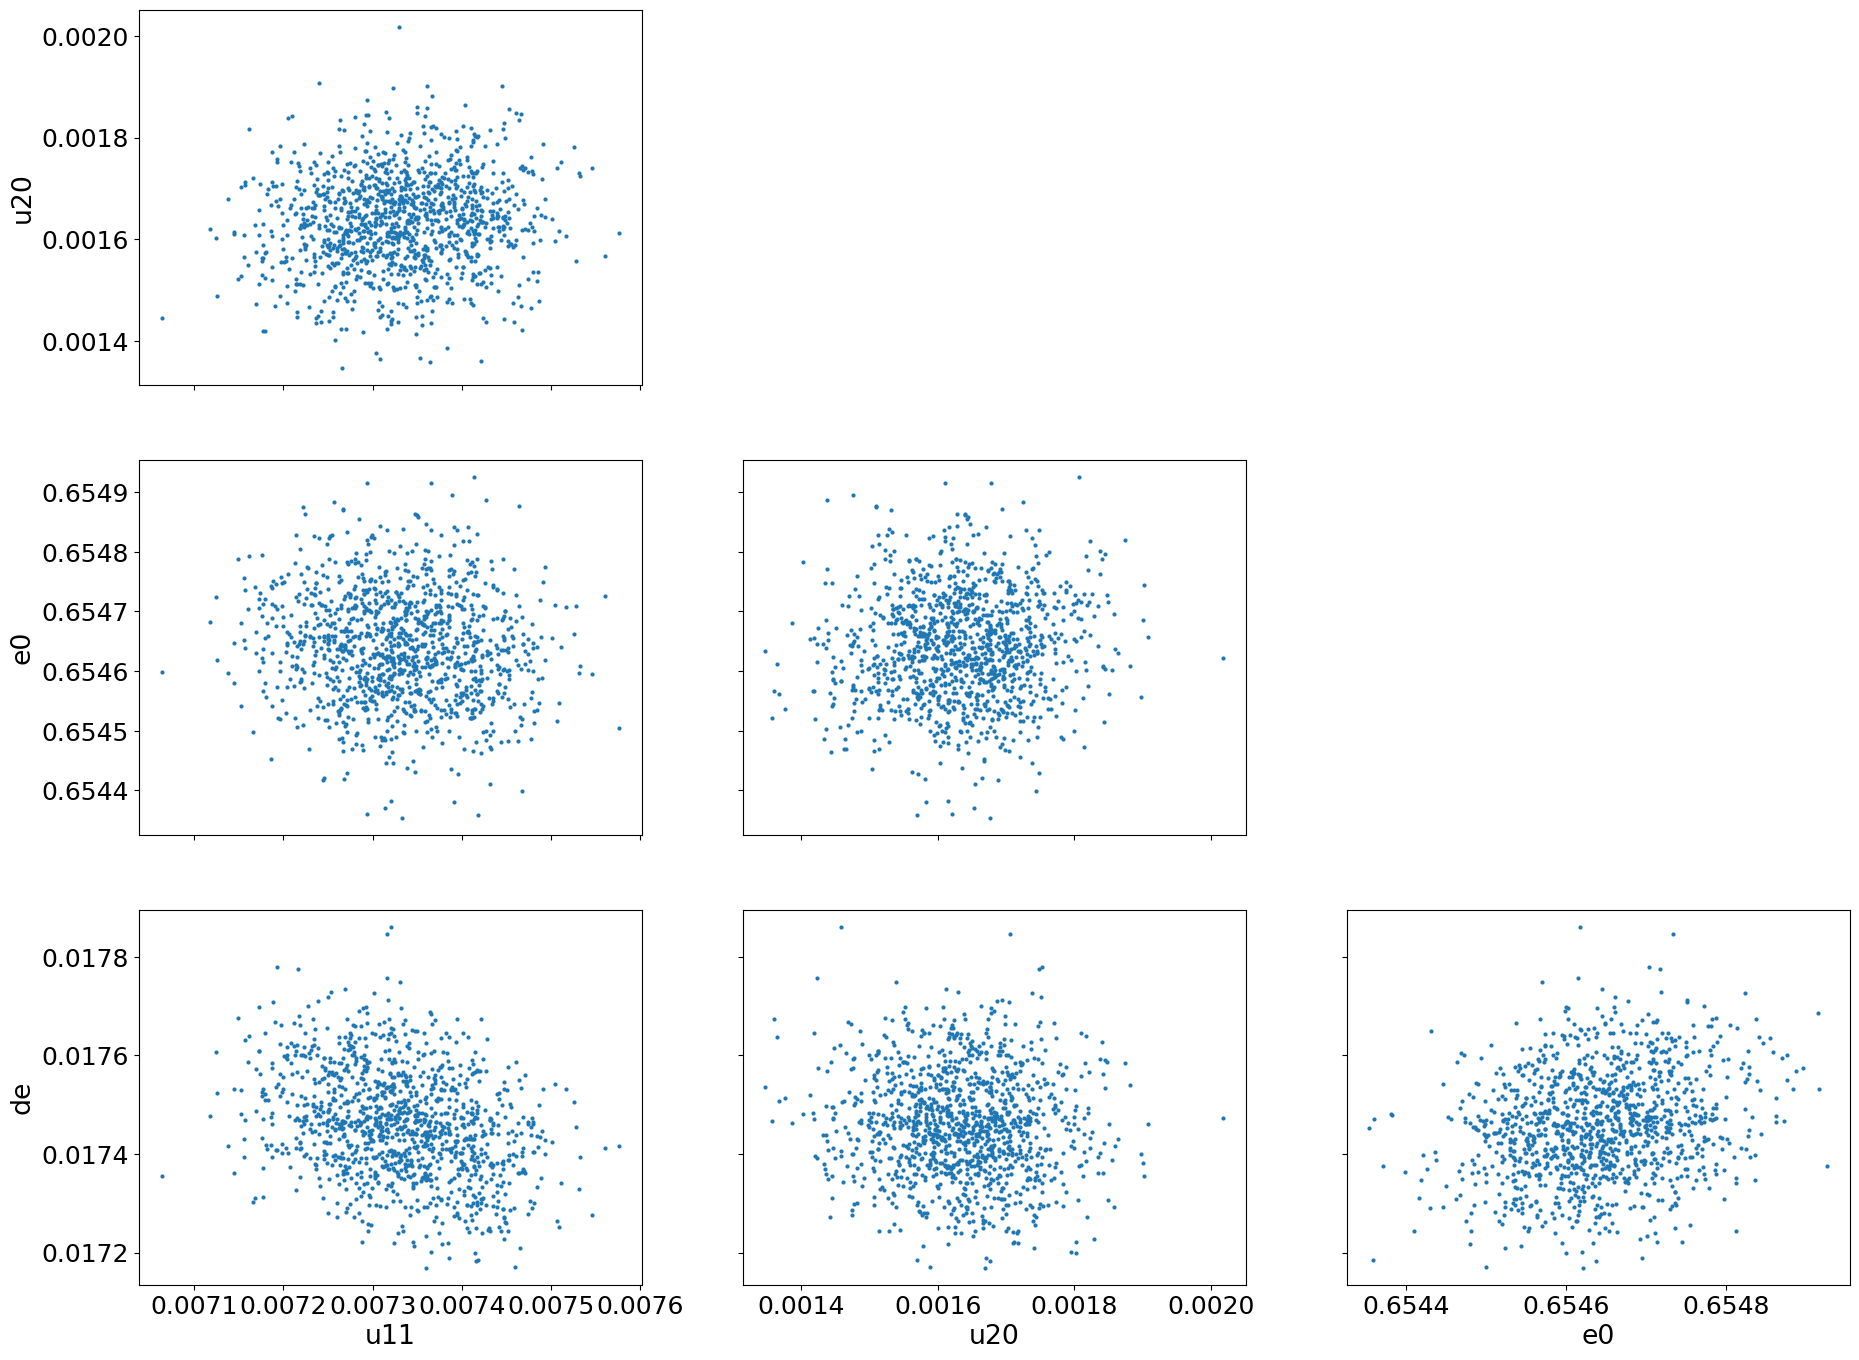

In [16]:
az.plot_pair(idata,
            var_names=['u11', 'u20','e0','de'],
            filter_vars="regex",           
            divergences=True,
            textsize=18)

In [31]:
#ff = az.plot_pair(idata,var_names=["u11", "u20"],marginals=True,figsize=(7, 7))
#sns.pairplot(idata)